<center>

## MAGICIAN: Mining and gAmblinG servIces sCrapIng and ANalysis

Matteo Martini 636694

In [2]:
mining_pool_url = "https://en.bitcoin.it/wiki/DeepBit9"
full_wallet_address = "https://www.walletexplorer.com/wallet/"


#Individuare nel DataSet tutte le transazioni relative a Deepbit.net,ovvero le transazioni che presentano almeno un indirizzo di input o di output appartenente a Deepbit_addrs.
#servizio scommesse = DiceOnCrack

## Setup Ambiente

In [3]:
# Librerie concesse
import pandas as pd

# Per scraping (scegline uno o entrambi, in base alle esigenze delle pagine)
from bs4 import BeautifulSoup
from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.chrome.options import Options

# Per formati efficienti (PyArrow)
import pyarrow as pa
import pyarrow.parquet as pq

# Utility
from pathlib import Path
from datetime import datetime

import numpy as np


from selenium.webdriver.support.select import Select
from selenium.webdriver.common.keys import Keys
import time
import requests
import re
from bs4 import BeautifulSoup

# Percorsi (aggiorna con il tuo percorso locale)
DATA_DIR = Path('./Datasets')   # metti qui i CSV scaricati

PARQUET_DIR = Path('./data_parquet')
PARQUET_DIR.mkdir(parents=True, exist_ok=True)
print('Environment ready.')

Environment ready.


## 1) Costruzione dei Dataframe dal Dataset

## Directory Datasets


In [4]:
transactions_csv = DATA_DIR / 'transactions.csv'
inputs_csv       = DATA_DIR / 'inputs.csv'
outputs_csv      = DATA_DIR / 'outputs.csv'
mapping_csv      = DATA_DIR / 'mapAddr2Ids8708820.csv'

## Definizone Data Type
Sapendo cosa contengono i file csv, possiamo forzare la conversione in determiinati tipi per ridurre l'impatto in memoria dei dataset

In [5]:
dtype_transactions = {
    "timestamp": np.int32,          # prima colonna: secondi (1231469xxx) rientra in int32
    "block_height": np.int32,              # seconda colonna: contatore 1…10 572 827
    "tx_id": np.int32,       # terza colonna: 1…214 562
    "prev_tx_id": np.int32,         # quarta colonna: seguono il tx_id precedente
    "is_coinbase": np.uint8,        # quinta colonna 0/1
    "fee": np.int32,                # sesta colonna: 0…100 000 (int32 più che sufficiente)
}


dtype_inputs = {
    "input_id": np.int32,
    "tx_id": np.int32,
    "prev_output_id": np.int32,
    "input_index": np.uint8,
}


dtype_outputs = {
    "col0":np.int32,
    "col1":np.int32,
    "col2":np.int8,
    "col3":np.int32,
    "col4":np.int64,
    "col5":"uint8"
}

dtype_mapping = {
    "address": "category",   # stringhe ripetute → category riduce drasticamente
    "address_id": "Int32",   # valori 0–8 708 820 entrano in 32 bit
}


columns_inputs = [
    "tx_id",
    "prev_tx_id",
    "prev_tx_pos"
]
columns_transactions = [
    "timestamp", "block_height", "tx_id",
     "is_coinbase", "fee"
]
columns_outputs = [
    "tx_id","position",
    "addressId","amount","script_type"
]
columns_mapping = [
    "hash", "addressId"
]

## Caricamento dei Dataset

In [6]:
transactions_csv = DATA_DIR / 'transactions.csv'
inputs_csv       = DATA_DIR / 'inputs.csv'
outputs_csv      = DATA_DIR / 'outputs.csv'
mapping_csv      = DATA_DIR / 'mapAddr2Ids8708820.csv'

transactions = pd.read_csv(transactions_csv,header=None,names=columns_transactions,dtype=dtype_transactions)
inputs_df    = pd.read_csv(inputs_csv,header=None,names=columns_inputs,dtype=dtype_inputs)
outputs_df   = pd.read_csv(outputs_csv,header=None,names=columns_outputs,dtype=dtype_outputs)
mapping_df   = pd.read_csv(mapping_csv,header=None,names=columns_mapping,dtype=dtype_mapping)

## Operazioni su Dataset

In [7]:
merged_outputs = outputs_df.merge(mapping_df,on="addressId",how="left")
display(merged_outputs)

,tx_id,position,addressId,amount,script_type,hash
0,0,0,0,5000000000,1,1A1zP1eP5QGefi2DMPTfTL5SLmv7DivfNa
1,1,0,1,5000000000,1,12c6DSiU4Rq3P4ZxziKxzrL5LmMBrzjrJX
2,2,0,2,5000000000,1,1HLoD9E4SDFFPDiYfNYnkBLQ85Y51J3Zb1
3,3,0,3,5000000000,1,1FvzCLoTPGANNjWoUo6jUGuAG3wg1w4YjR
4,4,0,4,5000000000,1,15ubicBBWFnvoZLT7GiU2qxjRaKJPdkDMG
...,...,...,...,...,...,...
24613794,10572825,0,8707915,1,2,1DYve98WqJQmx6cDdW2EQFpnqfwptjV4e9
24613795,10572825,1,6137715,9899999,2,1AdN2my8NxvGcisPGYeQTAKdWJuUzNkQxG
24613796,10572826,0,8707915,26651306,2,1DYve98WqJQmx6cDdW2EQFpnqfwptjV4e9
24613797,10572826,1,6137711,7991620447,2,1L4EThM6x3Rd2PjNbs1U136FpMq4Gmo3fJ


## 2) Recupero informazioni da WalletExplorer


### Definizione Funzioni Helper per Scraping

In [8]:
wallet_explorer_url = "https://www.walletexplorer.com/"

headers = {
    "User-Agent": (
        "Mozilla/5.0 (Windows NT 10.0; Win64; x64) "
        "AppleWebKit/537.36 (KHTML, like Gecko) "
        "Chrome/127.0.0.1 Safari/537.36"
    ),
    "Accept-Language": "en-US,en;q=0.9",
    "Accept-Encoding": "gzip, deflate, br",
    "Referer": "https://www.walletexplorer.com/",
}

In [9]:
def next_page(driver):
    #cerco il link alla prossima pagina
    for _ in ("Next","Last"):
        try:
            el = driver.find_element(By.XPATH, f'//div[@class="paging"]//a[contains(., "{_}")]')
            url = el.get_attribute("href")
            el.click()
            return url
        except:
            return None
        
def find_next_link(driver,element):
    try:
        el = driver.find_element(By.XPATH, f'//span[@class="showother"]//a[contains(., "{element}")]')
        url = el.get_attribute("href")
        el.click()
        return url
    except:
        return None

def scrape_step(driver):
    #recupero le entries
    soup = BeautifulSoup(driver.page_source, "html.parser")
    # seleziona tutti gli elementi che hanno l’attributo data-wallet-id
    wallet_elements = soup.select("td a[href^='/address/']") 
    # estrai il valore dell’attributo
    return [re.search(r"/address/([^/?#]+)", w.get("href")).group(1) for w in wallet_elements if w.get("href") and re.search(r"/address/([^/?#]+)", w.get("href"))]




### Definizione Funzione per Scraping

In [10]:
def scrape_wallet_explorer(wallet_name):
    driver = webdriver.Chrome()
    driver.get(wallet_explorer_url)
    
    #ricerca del wallet tramite form
    driver.find_element(By.NAME,'q').send_keys(wallet_name)
    driver.find_element(By.TAG_NAME,'form').submit()
    
    #mettere funzione di selenium
    time.sleep(1)
    
    #mostra wallet
    tri = find_next_link(driver,"show wallet addresses")
    if tri == None: return
    #mettere funzione di selenium
    time.sleep(1)

    try:
        while True:
            #recupero di tutti gli input/output della pagina
            yield from scrape_step(driver)

            if next_page(driver) == None:break;
    except:
            print('Something went wrong')
    finally:
        driver.close()    
   
#https://www.walletexplorer.com/wallet/


<center>

# Analisi Transazioni di DeepBit.Net

In [11]:
deepbit_transactions = set(scrape_wallet_explorer('DeepBit.net'))
print(len(deepbit_transactions))

2


### Recupero gli output appartenenti a Deepbit.net

In [12]:
# display(merged_outputs)
bnet_out = merged_outputs[merged_outputs["hash"].isin(deepbit_transactions)]
deepbit_out_transactions = transactions[transactions["tx_id"].isin(bnet_out["tx_id"].unique())]
assert len(deepbit_out_transactions) > 0

### Recupero le transazioni Coinbase

In [13]:

# transazioni che inviano a Deepbit     
deepbit_trans_id = deepbit_out_transactions["tx_id"].unique()
# display(deepbit_trans_id)

deepbit_inputs = inputs_df[inputs_df["tx_id"].isin(deepbit_trans_id)]
# display(deepbit_inputs)

coinbase_deepb = transactions[transactions["tx_id"].isin(deepbit_inputs["prev_tx_id"].tolist()) & transactions["is_coinbase"] == 1].copy()

### Considerazione dell'attività nel tempo

In [14]:
coinbase_deepb["timestamp"] = pd.to_datetime(coinbase_deepb["timestamp"],unit="s")
coinbase_deepb = coinbase_deepb.set_index("timestamp")
# display(coinbase_deepb)

<Axes: title={'center': 'Blocchi minati da Deepbit.net per mese'}, xlabel='timestamp'>

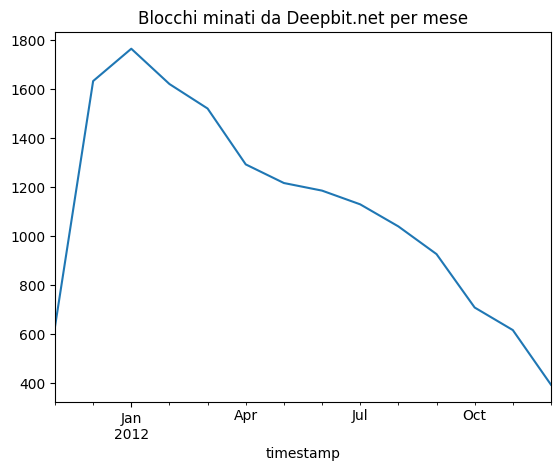

In [15]:
# Numero di transazioni per mese
monthly_counts = coinbase_deepb.resample('ME').size()
monthly_counts.plot(title='Blocchi minati da Deepbit.net per mese')

<Axes: title={'center': 'Blocchi minati da Deepbit.net per settimana'}, xlabel='timestamp'>

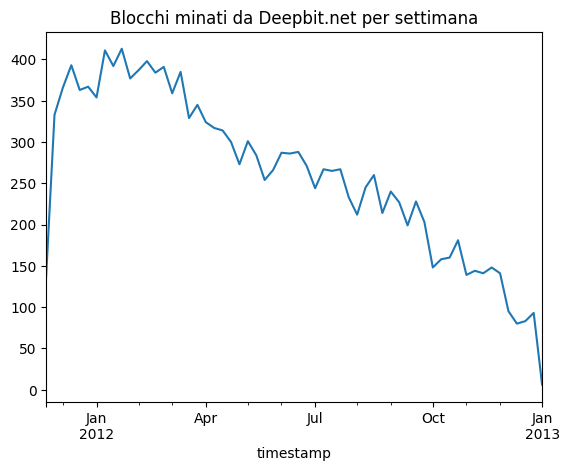

In [16]:
# Numero di transazioni per mese
weekly_counts = coinbase_deepb.resample('W').size()
weekly_counts.plot(title='Blocchi minati da Deepbit.net per settimana')

C:\Users\matte\AppData\Local\Temp\ipykernel_27548\524359246.py:2: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  yearly_counts = coinbase_deepb.resample('Y').size()


<Axes: title={'center': 'Blocchi minati da Deepbit.net per anno'}, xlabel='timestamp'>

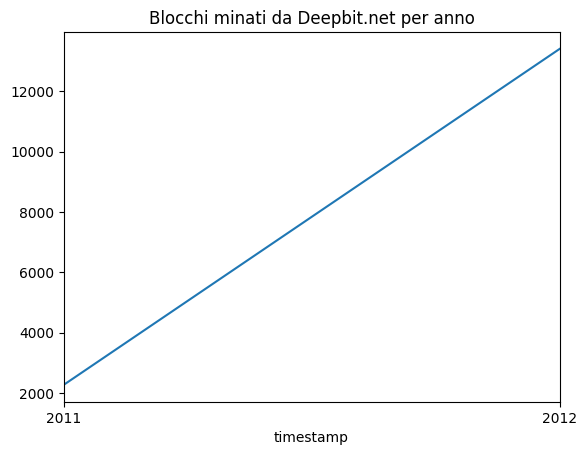

In [17]:
# Numero di transazioni per mese
yearly_counts = coinbase_deepb.resample('Y').size()
yearly_counts.plot(title='Blocchi minati da Deepbit.net per anno')

## 2)Distribuzione delle fee ai minatori

### Recupero gli amount di ogni transazione di input/output

In [18]:
amounts = inputs_df.merge(outputs_df,left_on=["prev_tx_id","prev_tx_pos"], right_on=["tx_id","position"],suffixes=('_input', '_output'))
input_amount = amounts.groupby('tx_id_input')["amount"].sum().rename('input_total')
output_amount = outputs_df.groupby('tx_id')['amount'].sum().rename('output_total')
# display(input_amount,output_amount)

In [19]:
fees = pd.concat([input_amount,output_amount],axis=1)
fees['fee'] = fees['input_total'] - fees['output_total']
fees = fees.reset_index().rename(columns={'index':'tx_id'})
fees = fees.merge(
    transactions[['tx_id', 'is_coinbase', 'block_height']],
    on='tx_id',
    how='left'
)
not_coinbase = fees["is_coinbase"] == 0
fees = fees[not_coinbase]
fee_per_block = fees.groupby('block_height')['fee'].sum().reset_index()
# display(fee_per_block)

## 3)Calcolo degli UTXO(Unspent Transaction Output)

In [20]:

diff = outputs_df.merge(
    amounts[['tx_id_output', 'position']],
    left_on=['tx_id', 'position'],
    right_on=['tx_id_output', 'position'],
    how='left',
    indicator=True
)
# Filtra quelli non trovati nel merge (cioè non spesi)
unspent_df = diff[diff['_merge'] == 'left_only'].copy()


### Ricavo i timestamp

In [21]:
UTXO_df = unspent_df.merge(transactions,how="left",on="tx_id")[["amount","timestamp"]]
UTXO_df["timestamp"] = pd.to_datetime(UTXO_df["timestamp"],unit="s")
UTXO_df = UTXO_df.set_index("timestamp")
display(UTXO_df)


,amount
timestamp,
2009-01-03 18:15:05,5000000000
2009-01-09 02:54:25,5000000000
2009-01-09 02:55:44,5000000000
2009-01-09 03:02:53,5000000000
2009-01-09 03:16:28,5000000000
...,...
2012-12-31 23:52:37,1
2012-12-31 23:52:37,9899999
2012-12-31 23:52:37,26651306


C:\Users\matte\AppData\Local\Temp\ipykernel_27548\3483965704.py:2: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  monthly_UTXO = UTXO_df.resample('Y').size()


<Axes: title={'center': 'UTXO per anni'}, xlabel='timestamp'>

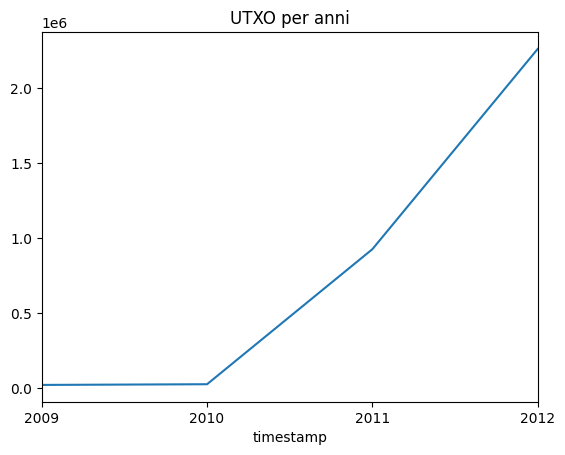

In [22]:
# Numero di transazioni per mese
monthly_UTXO = UTXO_df.resample('Y').size()
monthly_UTXO.plot(title='UTXO per anni')

## Costruzione Grafo Transazione tx_id = 1883820 

In [23]:
othersDeepbit = []

deepbit_hased_addresses = set(mapping_df[mapping_df["hash"].isin(deepbit_transactions)]["addressId"])

root_transaction = transactions[transactions["tx_id"] == 1883820];
root_output = outputs_df[outputs_df["tx_id"] == 1883820]

change_addresses_transactions = []

## Definizione Funzione Ricorsiva per ricostruire la catena di transazioni 

In [24]:
def chain_transactions(chain_output,othersDeepbit,change_addresses_transactions,change_addresses=[]):
    output_tx_id = chain_output["tx_id"]
    output_position = chain_output["position"]

    #maschere per ottenere l'input
    tx_id_mask = inputs_df["prev_tx_id"]== output_tx_id
    tx_pos_mask = inputs_df["prev_tx_pos"]==output_position
    
    #cerco il prossimo input della catena
    next = inputs_df[tx_id_mask & tx_pos_mask ]
    next_tx_id = int(next.iloc[0]["tx_id"])
    
    #maschere per ottenere l'output
    outputs_tx_id_mask = outputs_df["tx_id"] == (next_tx_id)
    
    #cerco gli output
    related_outputs = outputs_df[ outputs_tx_id_mask ]
    
    deepbit_matches = [address for address in related_outputs["addressId"] if address in deepbit_hased_addresses]

    othersDeepbit.extend(address for address in related_outputs["addressId"] if address not in deepbit_hased_addresses)

    if len(deepbit_matches) != 1:return change_addresses
    #ricavo il prossimo output
    chained = related_outputs[related_outputs["addressId"] == deepbit_matches[0]].iloc[0]
    change_addresses.append(int(chained["tx_id"]))
    #memorizzo il tx_id per poter riutilizzare le transazioni
    change_addresses_transactions.append(
    {
        "tx_id":      int(chained["tx_id"]),
        "position":   int(chained["position"]),
        "addressId":  int(chained["addressId"]),
        "amount":     float(chained["amount"])
    }
    )
    return chain_transactions(chained,othersDeepbit,change_addresses_transactions,change_addresses)

### ricostruisco la catena

In [25]:
ctx = chain_transactions(root_output.iloc[0],othersDeepbit,change_addresses_transactions)

## Rappresentazione della catena mediante grafo

In [26]:
import networkx as nx
import matplotlib.pyplot as plt

G = nx.DiGraph()
chain_tx_ids = ctx
differences =[]
# aggiungo archi tra tx consecutive
for i in range(len(chain_tx_ids) - 1):
    t1 = f't{i+1}'
    t2 = f't{i+2}'
    stamp1 = int(transactions[transactions["tx_id"] == change_addresses_transactions[i]["tx_id"]].iloc[0]["timestamp"])
    stamp2 = int(transactions[transactions["tx_id"] == change_addresses_transactions[i+1]["tx_id"]].iloc[0]["timestamp"])
    dt = stamp1 - stamp2
    da = change_addresses_transactions[i]["amount"] - change_addresses_transactions[i+1]["amount"]
    
    if dt < 0 : dt *= -1 

    differences.append({"delta_time":dt,"delta_amount":da})
    
    G.add_edge(t1, t2,label = change_addresses_transactions[i]["amount"])



In [27]:
display(othersDeepbit)
othersDeepbit = [mapping_df[mapping_df["addressId"] == address].iloc[0]["hash"] for address in othersDeepbit]
display(othersDeepbit)

[1338454,
 2538279,
 2155396,
 1867968,
 382527,
 2531300,
 1000193,
 1537228,
 1963535,
 1989361,
 1128358,
 658550,
 1202633,
 1841213,
 1721169,
 1526177,
 1629799,
 655864,
 1755771,
 1709751,
 560690,
 2347956,
 563272,
 906953,
 1776029,
 1726033,
 485364,
 1389828,
 2110059,
 1686495,
 2139628,
 2043517,
 1411098,
 1329696,
 2480375,
 2291025,
 2538610,
 1334281,
 1455117,
 501392,
 946326,
 2426982,
 777625,
 1838000,
 2291492,
 830089,
 2527075,
 2039422,
 1537228,
 2381584,
 1695358,
 2047322,
 2438272,
 2446683,
 2402917,
 2268878,
 2492560,
 2420533,
 2518124,
 1695829,
 2314280,
 2538985,
 598273,
 630233,
 1878683,
 1845258,
 1738570,
 2378850,
 2080758,
 2539074]

['13anmvSzPzmSxaBQd3Rz2SzdB323hs45vu',
 '12NAMxG63ihkS3RxAqxTAtuNT147C1HMRw',
 '1J7UAz6yLqCnTELtrtMNbxhtwtMCaRhUTv',
 '17TUBCnEyYZkrGMr87eJkjnzA5kXNgguEL',
 '1BC1QZyEc7Rs7DJEZbYk52Wx3FUNoJkTbH',
 '1CnGHdHhnSJw5DnsM8RMmTyGWPTVRRMqCd',
 '1NWBTs8LK7kJUDKe31uncF7nWpaUH14AMg',
 '1EeCGpVttBiRyaeXxTtLAiQdrqpgQ3jsEQ',
 '13xdmfTsT1FwY6TBYa4Q15kJqWDusGUWTS',
 '1KjyGQAFRhgjqyeZ4mYDdqECq72WEz2Xtc',
 '1CfTAtLjp8wv5uLbZo6s4meRvoqBPEhWR8',
 '1BF5k3zbvvWrGb1fXwQWU3LZLWpsZ3VBcG',
 '132z7f7nNWeApw4jTTNYAMjiziUdupv5Jn',
 '13UwVjAGqkEXuuqRzgoQs5gxGAxyJwXT8K',
 '17cW1jeH3CguRm3smHDMUqh8LxJrpxdgQN',
 '1MbHPg41EEvaazsBRadekD451jdJ1HY4QT',
 '17dbngcpdF6dbTdzSmmCGwKvQSjeSR39HG',
 '1LJiKfFYQdmPYozab6wdbEhJ95kvLTxBhU',
 '163XTWh6NUhs7CWLjzbKj3Ug1wdKzthXjX',
 '1JvCbjK1LLYKrgvKtyiSnHzg5k4168eHjX',
 '12ys4qSPDtKi9mgdFTxb57gZSBthNdPhFS',
 '1PkKqRsnfnJtWMGZiHjXndaitWYzoTJKAq',
 '18YzZXbnTPFhtH5Mv5KcGKbduUX1w67xos',
 '1CqWkeHGfmqZkDqoXZDDbbVkdKNmchfd6c',
 '19pRw3V7Df48XxYJrJeavHQnZS2QA5hDbA',
 '1BkwbNKCXvi62T8RkmtzNZN

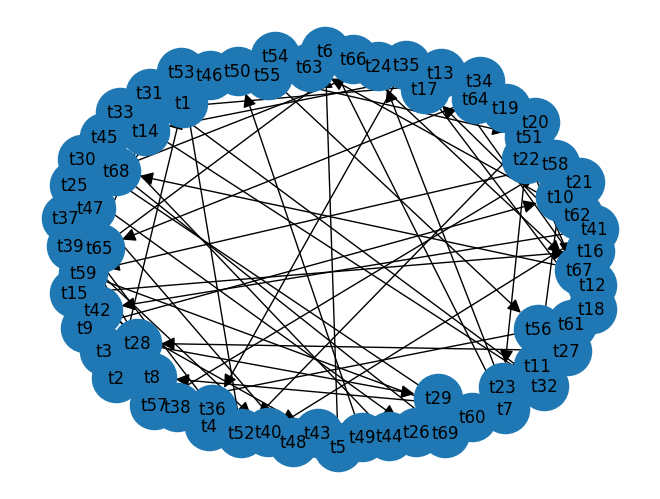

In [28]:
pos = nx.spring_layout(G, k=1000000000000000)

nx.draw(G, pos, with_labels=True, node_size=1200, arrowsize=20)
plt.show()

## Grafico Descrittivo

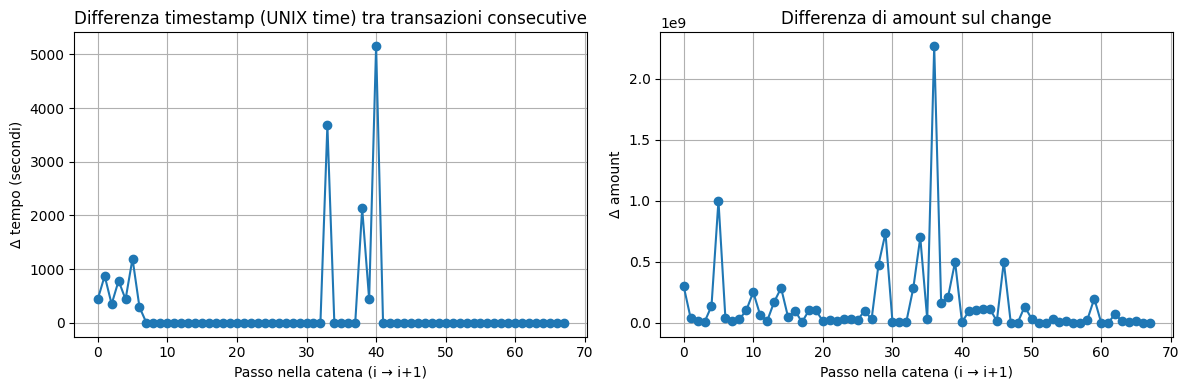

In [29]:
import matplotlib.pyplot as plt

diffs_df = pd.DataFrame(differences)
x = range(len(diffs_df))

plt.figure(figsize=(12,4))

# Δ tempo
plt.subplot(1,2,1)
plt.plot(x, diffs_df["delta_time"], marker="o")
plt.xlabel("Passo nella catena (i → i+1)")
plt.ylabel("Δ tempo (secondi)")
plt.title("Differenza timestamp (UNIX time) tra transazioni consecutive")
plt.grid(True)

# Δ amount
plt.subplot(1,2,2)
plt.plot(x, diffs_df["delta_amount"], marker="o")
plt.xlabel("Passo nella catena (i → i+1)")
plt.ylabel("Δ amount")
plt.title("Differenza di amount sul change")
plt.grid(True)

plt.tight_layout()
plt.show()


## Secondo passo di scraping da WalletExplorer per individuare indirizzi deanonimizzati

In [30]:
scraper_url = 'https://www.walletexplorer.com/address/'
headers2 = {
    "User-Agent": (
        "Mozilla/5.0 (Windows NT 10.0; Win64; x64) "
        "AppleWebKit/537.36 (KHTML, like Gecko) "
        "Chrome/127.0.0.1 Safari/537.36"
    ),
    "Accept-Language": "en-US,en;q=0.9",
    "Accept-Encoding": "gzip, deflate, br",
    "Referer": "https://www.walletexplorer.com/address/",
}

def is_deanonimizzato(wallet_name):
    w = wallet_name.lower()
    # 1) se contiene un dominio → servizio reale
    if any(ext in w for ext in [".com", ".net", ".org", ".io"]):
        return True
    
    # 2) se è uno dei servizi noti → deanonimizzato
    known = ["deepbit", "diceoncrack", "mtgox", "bitcoinmarket", "slush", "bitminter"]
    if any(k in w for k in known):
        return True
    
    # se non rientra nei casi sopra → NON deanonimizzato
    return False

def identify_address(address):
    res = requests.get(f'{wallet_explorer_url}/address/{address}',headers=headers2)
    soup = BeautifulSoup(res.text,"html.parser")
    wallet_name = soup.select_one('span.wallet_name').text
    
    match = re.search(r"\[(.*?)\]", wallet_name)
    
    if match:
        wallet_name = match.group(1)

    return is_deanonimizzato(wallet_name);

def scrape_wallet_explorer_2(addresses):
    return [identify_address(address) for address in addresses]

In [31]:

others_deanon = [identify_address(address) for address in othersDeepbit]


In [32]:
print(len(others_deanon))
deanonized = set(address for address in others_deanon if address == True)
print(deanonized)

70
{True}


### Riflessione sui risultati

Effettuando lo scraping degli indirizzi contenuti nell’insieme OthersDeepbit, solo un indirizzo risulta associato a un wallet deanonimizzato su WalletExplorer.

Questo risultato è coerente con il periodo storico del dataset (2009–2012), in cui la maggior parte degli indirizzi apparteneva a utenti privati e WalletExplorer era in grado di identificare solo alcuni grandi servizi pubblici (exchange, mining pool, gambling, merchant).

Gli indirizzi esterni che compaiono nella catena di pagamenti di Deepbit rappresentano prevalentemente utenti individuali della mining pool, che generavano nuovi indirizzi ad ogni transazione e non lasciavano tracce pubbliche della loro identità.

Il fatto che quasi tutti i wallet rimangano anonimi conferma quindi che la catena analizzata non coinvolge servizi pubblici noti e che WalletExplorer non dispone di informazioni sufficienti per collegare questi indirizzi a entità reali.

<center>

  # Analisi del servizio di gambling

### Recupero gli indirizzi da WalletExplorer

In [33]:
diceoncrack_addresses = set(scrape_wallet_explorer('DiceonCrack'))
print(len(diceoncrack_addresses))

28


## Individuo le transazioni relative a DiceOnCrack nel dataset

In [34]:
doc_outs = merged_outputs[merged_outputs["hash"].isin(diceoncrack_addresses)]
print(len(doc_outs))

doc_inputs  = inputs_df.merge(doc_outs[["tx_id","position","addressId"]].rename(columns={"tx_id":"prev_tx_id","position":"prev_tx_pos"}),how="inner",on=["prev_tx_id","prev_tx_pos"])
# print(len(doc_inputs))
# display(doc_inputs)

doc_trans_id =  np.union1d(doc_inputs["tx_id"].unique(),doc_outs["tx_id"].unique())

doc_trans = transactions[transactions["tx_id"].isin(doc_trans_id)].sort_values("block_height")



17034


In [35]:
display(doc_trans)
display(doc_trans_id)

,timestamp,block_height,tx_id,is_coinbase,fee
7983518,1350241678,203280,7983516,0,0
7985452,1350247008,203289,7985450,0,0
7985944,1350248550,203290,7985942,0,50000
7986874,1350250440,203292,7986872,0,0
7987819,1350252686,203295,7987817,0,0
...,...,...,...,...,...
10565382,1356972028,214521,10565380,0,50000
10565384,1356972028,214521,10565382,0,50000
10565389,1356972028,214521,10565387,0,50000
10565391,1356972028,214521,10565389,0,50000


array([ 7983516,  7985450,  7985942, ..., 10565387, 10565389, 10569508],
      shape=(16702,))

### Controllo le transazioni di un determinato intervallo temporale, dividendole in base al block_height e soprattutto ricavando il loro addressId, con accorgimenti per rendere più light lo scraping

In [36]:
day = pd.to_datetime("2012-12-26").date()
#elimino i wallet_address di DOC già noti "1CRACKLiwFrZbAQz1yb9w22onHCMLbiMTY"
# doc_wallet_addresses = ["1CRACKLiwFrZbAQz1yb9w22onHCMLbiMTY"]
doc_wallet_addresses = [""]
doc_trans["timestamp"] = pd.to_datetime(doc_trans["timestamp"],unit='s')

desired_day_trans = doc_trans[doc_trans["timestamp"].dt.date == day]

unique_heights = desired_day_trans["block_height"].unique().tolist()

#proviamo col 26 dicembre 2012
def height_mask(height): return desired_day_trans["block_height"] == height 

def map_outputs_mask(input): return (merged_outputs["tx_id"] == input["prev_tx_id"]) & (merged_outputs["position"] == input["prev_tx_pos"])

def all_tx_inputs(txs):
    address_set = [merged_outputs[map_outputs_mask(trans)].iloc[0]["hash"] for tx in txs for _,trans in inputs_df[inputs_df["prev_tx_id"] == tx].iterrows()]
    filtered = []
    for address in address_set:
        if address not in doc_wallet_addresses:
            filtered.append(address)
    return filtered


In [37]:
same_heights = [{height:all_tx_inputs(desired_day_trans[height_mask(height)]["tx_id"].tolist())} for height in unique_heights]

## Calcolo i cluster

In [38]:
def identify_address_2(address):
    res = requests.get(f'{wallet_explorer_url}/address/{address}',headers=headers2)
    soup = BeautifulSoup(res.text,"html.parser")
    wallet_name = soup.select_one('span.wallet_name').text
    
    match = re.search(r"\[(.*?)\]", wallet_name)
    
    if match:
        wallet_name = match.group(1)

    return wallet_name;

def scrape_wallet_explorer_3(dict):
    wallets = []
    for height in dict:
        # print(dict[height])
        if len(dict[height])<1:return ["vuoto"]
        for addr in dict[height]:
            wallet = identify_address_2(addr)
            wallets.append(wallet)
    return wallets

clusters = []
for porcodio in same_heights:
    k = list(porcodio.keys())[0]

    walletes = scrape_wallet_explorer_3(porcodio)
    clusters.append({
        k:walletes
    })

display(clusters)

[{213624: ['DiceOnCrack.com', '3dfb5f1daa']},
 {213625: ['3dfb5f1daa']},
 {213630: ['12005f5edd', 'DiceOnCrack.com']},
 {213634: ['DiceOnCrack.com']},
 {213645: ['DiceOnCrack.com', '3dfb5f1daa', '3dfb5f1daa']},
 {213651: ['12005f5edd', '12005f5edd', '12005f5edd', 'DiceOnCrack.com']},
 {213653: ['3dfb5f1daa',
   'DiceOnCrack.com',
   '3dfb5f1daa',
   'DiceOnCrack.com',
   'DiceOnCrack.com']},
 {213654: ['3dfb5f1daa',
   '12005f5edd',
   'DiceOnCrack.com',
   '12005f5edd',
   '3dfb5f1daa',
   '3dfb5f1daa']},
 {213659: ['12005f5edd', '12005f5edd', '12005f5edd', 'DiceOnCrack.com']},
 {213669: ['12005f5edd', 'DiceOnCrack.com']},
 {213730: ['DiceOnCrack.com',
   'DiceOnCrack.com',
   'DiceOnCrack.com',
   'DiceOnCrack.com']},
 {213731: ['vuoto']},
 {213739: ['12005f5edd', '12005f5edd']},
 {213740: ['12005f5edd']}]

## Analisi dei Cluster

In [39]:
def clusterize(cluster,data):
    k = list(data.keys())[0]
    for wallet in data[k]:
        if wallet not in cluster:
            cluster[wallet] = 1
        else:
            cluster[wallet] +=1


real_cluster = {}
for blocks in clusters:
    chiave = list(blocks.keys())[0]
    real_cluster[chiave] = {}
    clusterize(real_cluster[chiave],blocks)

display(real_cluster)

{213624: {'DiceOnCrack.com': 1, '3dfb5f1daa': 1},
 213625: {'3dfb5f1daa': 1},
 213630: {'12005f5edd': 1, 'DiceOnCrack.com': 1},
 213634: {'DiceOnCrack.com': 1},
 213645: {'DiceOnCrack.com': 1, '3dfb5f1daa': 2},
 213651: {'12005f5edd': 3, 'DiceOnCrack.com': 1},
 213653: {'3dfb5f1daa': 2, 'DiceOnCrack.com': 3},
 213654: {'3dfb5f1daa': 3, '12005f5edd': 2, 'DiceOnCrack.com': 1},
 213659: {'12005f5edd': 3, 'DiceOnCrack.com': 1},
 213669: {'12005f5edd': 1, 'DiceOnCrack.com': 1},
 213730: {'DiceOnCrack.com': 4},
 213731: {'vuoto': 1},
 213739: {'12005f5edd': 2},
 213740: {'12005f5edd': 1}}

Calcolo della dimensione media dei cluster

In [ ]:

for block in real_cluster:
    i = 0
    mean = 0 
    for cluster in real_cluster[block]:
        dim = real_cluster[block][cluster]
        if dim<2:continue
        i+=1
        mean+=dim
        print()
    mean = mean/i
    display(f'Block Height:{block}, num cluster: {i}, mean:{mean}')
    mean = 0
    i = 0

1
1
1
1
1
1
1
2
3
1
2
3
3
2
1
3
1
1
1
4
1
2
1
